Importation des library

In [1]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import anywidget
import os
plt.style.use('dark_background')

Chargement des données

In [2]:
# Télécharger les données (Utilise Python Binance)
# a PARTIR D'une date jusqu'a aujourd'hui (intervale 15 minutes)
symbol = ['ETHUSDT']
#day
time = "5m"
# Téléchargement des données
data = vbt.BinanceData.download(
    symbol, 
    start='2025-11-01', 
    interval=time,
    tz_convert='Europe/Paris',
)

0it [00:00, ?it/s]

Mise en forme des données

In [3]:
# Agencement des données + index + mis à l'heure de paris
df_raw = data.get(['Close','Open','High','Low','Volume']).copy()
df_raw.tail()

,Close,Open,High,Low,Volume
Open time,,,,,
2025-12-30 19:20:00+01:00,2976.72,2975.23,2977.41,2972.15,743.3813
2025-12-30 19:25:00+01:00,2975.33,2976.73,2977.88,2970.16,1319.9323
2025-12-30 19:30:00+01:00,2975.94,2975.33,2976.46,2974.41,751.6215
2025-12-30 19:35:00+01:00,2974.27,2975.94,2978.35,2974.26,339.5392
2025-12-30 19:40:00+01:00,2974.46,2974.27,2974.46,2973.15,230.3152


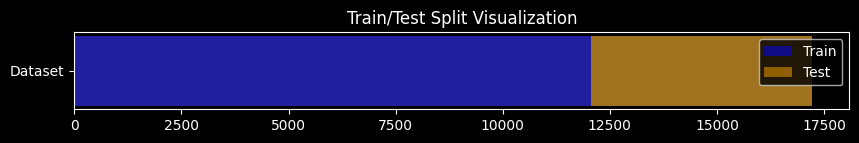

In [4]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.7*len(df_raw))
train_data = df_raw.iloc[:split_idx]
test_data = df_raw.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(df_raw)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(df_raw)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [5]:
# Selection du train_set comme données d'entrainement
df = test_data.copy()

In [8]:
import vectorbt as vbt
import pandas as pd
import plotly.graph_objects as go

close = df['Close']

# ================================================
# 1) Indicateurs SMA
# ================================================
sma20 = vbt.MA.run(close, window=20).ma
sma50 = vbt.MA.run(close, window=50).ma
sma200 = vbt.MA.run(close, window=200).ma   # non utilisée pour les signaux

# ================================================
# 2) Signaux basés UNIQUEMENT sur les croisements
# ================================================
entries = sma20.vbt.crossed_above(sma200)
exits   = sma20.vbt.crossed_below(sma50)

# ================================================
# 3) Backtest
# ================================================
pf = vbt.Portfolio.from_signals(
    close,
    entries,
    exits,
    init_cash=10_000,
    fees=0.001,
    slippage=0.001,
    freq='5m'
)

# ================================================
# 5) Résultats
# ================================================
print(pf.stats())

# ================================================
# 6) Chart : Candles + SMA + Signaux
# ================================================
fig = go.Figure()

# --- Bougies
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=close,
    name="Bougies",
    increasing_line_color='rgba(0,200,0,0.6)',  # vert transparent
    decreasing_line_color='rgba(200,0,0,0.6)',  # rouge transparent
    increasing_fillcolor='rgba(0,200,0,0.3)',
    decreasing_fillcolor='rgba(200,0,0,0.3)'
))

# --- Moyennes mobiles
fig.add_trace(go.Scatter(x=df.index, y=sma20, mode="lines", name="SMA 20", line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df.index, y=sma50, mode="lines", name="SMA 50", line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df.index, y=sma200, mode="lines", name="SMA 200", line=dict(color='red')))

# --- Signaux Entrées
fig.add_trace(go.Scatter(
    x=df.index[entries],
    y=close[entries],
    mode='markers',
    marker=dict(color='green', size=8),
    name='Buy'
))

# --- Signaux Sorties
fig.add_trace(go.Scatter(
    x=df.index[exits],
    y=close[exits],
    mode='markers',
    marker=dict(color='red', size=8),
    name='Sell'
))

# --- Paramètres graphiques
fig.update_layout(
    title="Stratégie SMA Cross — Bougies + Signaux",
    xaxis_title="Date",
    yaxis_title="Prix",
    xaxis_rangeslider_visible=False,
    template="plotly_dark",
    height=800
)

fig.show()
pf.plot().show()


Start                         2025-12-12 21:00:00+01:00
End                           2025-12-30 19:40:00+01:00
Period                                 17 days 22:45:00
Start Value                                     10000.0
End Value                                   8628.839164
Total Return [%]                             -13.711608
Benchmark Return [%]                          -3.273997
Max Gross Exposure [%]                            100.0
Total Fees Paid                              451.696534
Max Drawdown [%]                              15.298796
Max Drawdown Duration                  16 days 23:05:00
Total Trades                                         25
Total Closed Trades                                  25
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                       20.0
Best Trade [%]                                 1.981855
Worst Trade [%]                               -5